In [1]:
from rdkit import Chem
import pandas as pd
from rdkit.Chem import PandasTools

from IPython.display import HTML
def show_df(df):
    return HTML(df.to_html(notebook=True))

In [2]:
moonshot_file = "../../covid_submissions_all_info.csv"
df = pd.read_csv(moonshot_file)

/home/nichrun/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (3,6,7,9,10,11,12,13,14,15,18,19,27,28,29,30,31,32,33,34,35,36,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,66,67,69,70,71,72,73,74,75,76,84,85,86,87,89,90,91,92,93,94,95,96,104,105,106,107,109,110,111,112,113,114,115,116,124,125,126,127,129,130,131,132,133,134,135,136,144,145,146,147,149,150,151,152,153,154,155,156,164,165,166,167,169,170,171,172,173,174,175,176,184,185,186,187,189,190,191,192,193,194,195,196,204,205,206,207,209,210,211,212,213,214,215,216,224,225,226,227,229,230,231,232,233,234,235,236,244,245,246,247,249,253,254,255,256,257,258,259,275,276) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df[["SMILES", "CID"]]

,SMILES,CID
0,N#Cc1ccccc1NC(=O)Cc1c[nH]c2ncccc12,ANT-DIA-3c79be55-1
1,N#Cc1ccccc1NC(=O)Cc1cccnc1,ANT-DIA-3c79be55-2
2,CCNc1ccc(C#N)c(NC(=O)Cc2c[nH]c3ncccc23)c1,ANT-DIA-3c79be55-3
3,CS(=O)(=O)Cc1ccc(C(=O)Nc2cccnc2)o1,ANT-DIA-3c79be55-4
4,O=C(Nc1cccnc1)c1ccc(N2CCC(O)CC2)o1,ANT-DIA-3c79be55-5
...,...,...
20992,CC(C)NCCOc1ccc2cncc(N3CCC4(CN(S(=O)(=O)CC5(C#N...,MAT-POS-1a788f51-3
20993,CC(C)(C)NCCOc1ccc2cncc(N3CCC4(CN(S(=O)(=O)CC5(...,MAT-POS-1a788f51-4
20994,O,NIC-UNK-a1379f79-1
20995,CO,NIC-UNK-a1379f79-2


In [38]:
df = df[df["ASSAYED"]]

In [39]:
# Preclinical drug 
#https://www.medchemica.com/hot-news-from-medchemica-and-the-covid-moonshot-team/

preclinical_target = "MAT-POS-e194df51-1"
preclinical_target_row = df[df["CID"] == preclinical_target]

Drug: MAT-POS-e194df51-1


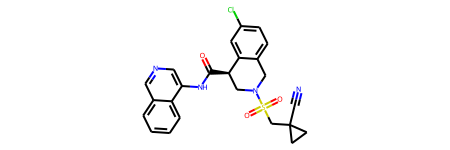

In [40]:
print(f"Drug: {preclinical_target}")
target_mol = Chem.MolFromSmiles(preclinical_target_row.iloc[0]["SMILES"])
target_mol

# Exploring Murcko

In [51]:
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import rdchem

def GetTrueScaffold(mol,generic=False):
    #Not sure if hybridisation of dummy atom is correct
    #Not sure on properties
    #Seems to work as desired
    """
    Takes RDKit mol object
    Returns mol object of the murcko scaffold with original algorithm
    Stereochemistry is lost
    """
    mol = MurckoScaffold.GetScaffoldForMol(mol)
    atom_to_remove = []
    atom_to_clean = []
    
    for a in mol.GetAtoms():
        #Remove chirality
        mol.GetAtomWithIdx(a.GetIdx()).SetChiralTag(Chem.ChiralType.CHI_UNSPECIFIED)
        
        #For atoms bonded to only one other atom, these must be removed
        if len(a.GetBonds()) == 1:
            #Get index of atom to delete and append to deletion list
            atom_to_remove.append(a.GetIdx())

    #If there are atoms to delte
    if len(atom_to_remove) > 0:
        #Create an editable molecule (now RW)
        emol = rdchem.RWMol(mol)
        #Every time an atom is delted the index changes
        #Deletion list must be reversed to avoid rogue deletions
        for a in atom_to_remove[::-1]:
            #Remove atom by index a
            emol.RemoveAtom(a)
    #If the molecule is already the correct murcko scaffold set emol = mol
    else:
        emol = mol
    
    #This line used to cause errors
    #SanitizeMol(emol) often failed due to aromaticity
    #Attempts to solve this included replacing previously bonded atoms with the
    #wild card *
    #It seems clearing aromatic flags solved the issue
    try:
        #Clearing aromatic flags seems to fix everything
        Chem.Kekulize(emol,clearAromaticFlags=True)
        Chem.SanitizeMol(emol)
    except:
        #Error
        #Will show the input molecule and attempted editted molecule (before sanitization attempt)
        display("Input Mol")
        display(mol)
        display("Output Emol")
        display(emol)
        raise ("Error in santisation of new molecule")
        return False
    
    #The above procedure will remove all remaining decorating groups on scaffold
    #In some cases (like sulfonyl) this will leave an aliphatic chain
    #Additional application of MurckoScaffold algorithm is needed
    #However the RDKit implementation is sufficient 
    emol = MurckoScaffold.GetScaffoldForMol(emol)
    
    #If the generic scaffold is desired (Flag), make generic
    if generic:
        emol = MurckoScaffold.MakeScaffoldGeneric(emol)

    #Return the molecule
    return emol

In [41]:
from rdkit.Chem.Scaffolds import MurckoScaffold

In [84]:
target_scaffold = GetTrueScaffold(target_mol)
#target_scaffold = Chem.MolFromSmiles('c1ccc2c(c1)CNCC2CNc1cncc2ccccc12')

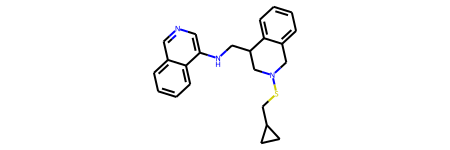

In [85]:
target_scaffold

In [86]:
#Chem.MolFromSmiles('c1ccc2c(c1)CNCC2CNc1cncc2ccccc12')

In [125]:
t= Chem.MolFromSmiles("[S](=O)(=O)(N4CC(C(=O)NC2=C1C=CC=CC1=CN=C2)C3=C(C=CC(=C3)Cl)C4=O)")

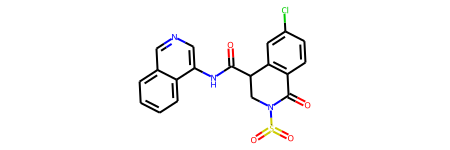

In [126]:
t

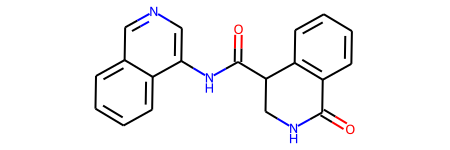

In [127]:
target_scaffold = MurckoScaffold.GetScaffoldForMol(t)
target_scaffold

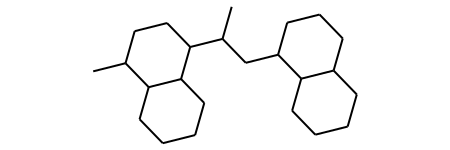

In [128]:
target_scaffold_generic = MurckoScaffold.MakeScaffoldGeneric(target_scaffold)
target_scaffold_generic

In [129]:
smiles_search = Chem.MolToSmiles(t)

In [130]:
smiles_list = list(df["SMILES"])
names_list = list(df["CID"])
IC50_list = list(df["f_avg_IC50"])

names_list = (x+"\n"+str(round(y,2)) for x,y in zip(names_list, IC50_list))

ms = [(Chem.MolFromSmiles(x), y) for x,y in zip(smiles_list, names_list)]

In [136]:
"""for x in ms:
    print(type(x))
    print(smiles_search)
    if x.HasSubstructMatch(smiles_search):
        print("yes")
"""
subms = [(x,y) for x,y in ms if x.HasSubstructMatch(target_scaffold)]

In [137]:
len(subms)

119

In [138]:
from rdkit.Chem import AllChem
from rdkit.Chem import Draw,rdDepictor

In [139]:
mols_to_show = [x for x,y in subms]
names_to_show = [y for x,y in subms]

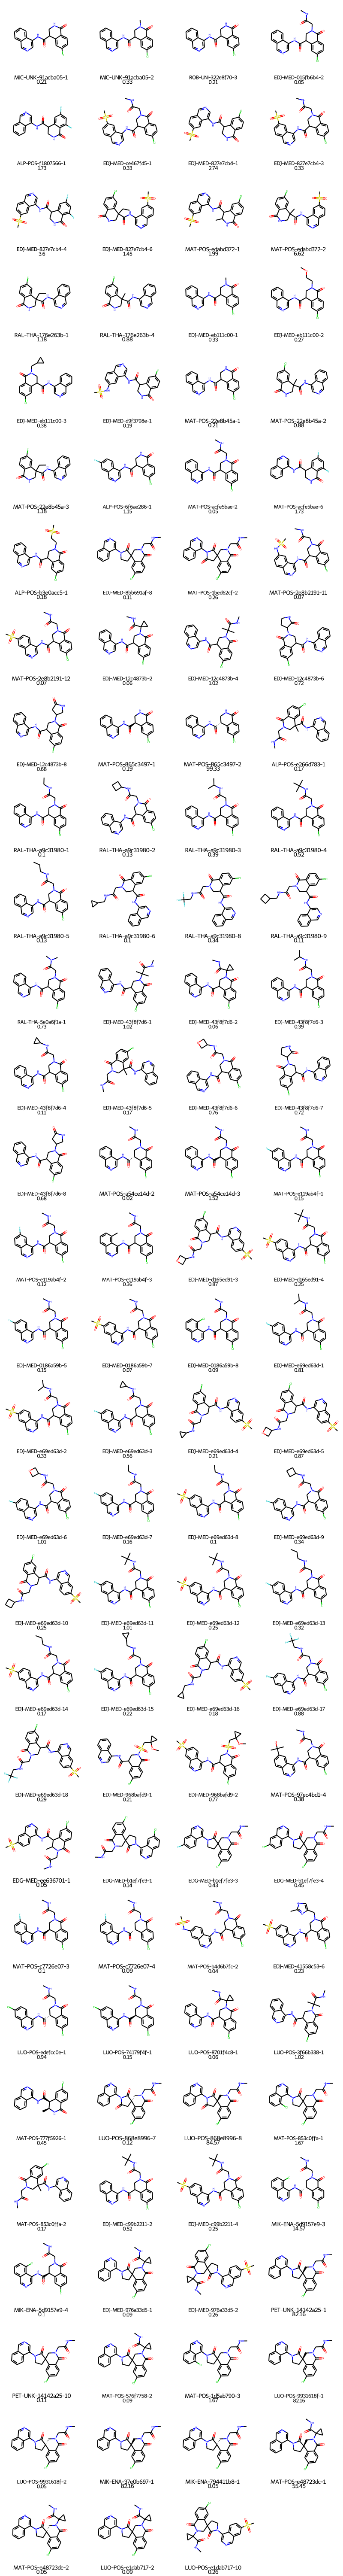

In [140]:
#net = rdScaffoldNetwork.CreateScaffoldNetwork([flu],params)
#nodemols = [Chem.MolFromSmiles(x) for x in net.nodes]

Draw.MolsToGridImage(mols_to_show,legends=names_to_show,molsPerRow=4, maxMols=200)

# Generic Matches

In [16]:
ms_generic = []
fail_smiles = []

for c,(x,y) in enumerate(zip(smiles_list, names_list)):
    try:
        ms_generic.append((MurckoScaffold.MakeScaffoldGeneric(Chem.MolFromSmiles(x)), y))
    except:
        fail_smiles.append((x, y))

In [17]:
subms_generic = [(x,y) for x,y in ms_generic if x.HasSubstructMatch(target_scaffold_generic)]

In [ ]:
len(ms_generic)

In [ ]:
len(subms_generic)

In [ ]:
#Whats different?
set1 = set([y for x,y in subms])
set2 = set([y for x,y in subms_generic])

In [ ]:
others = list(set2-set1)

# Attempted Allignment

In [ ]:
other_strings = list(df[df['CID'].isin(others)]["SMILES"])
mol_array = [Chem.MolFromSmiles(x) for x in other_strings]

Draw.MolsToGridImage(mol_array,legends=list(df[df['CID'].isin(others)]["CID"]),molsPerRow=5)

In [ ]:
Draw.MolsToGridImage(mols_to_show,legends=names_to_show,molsPerRow=5,returnPNG=True)

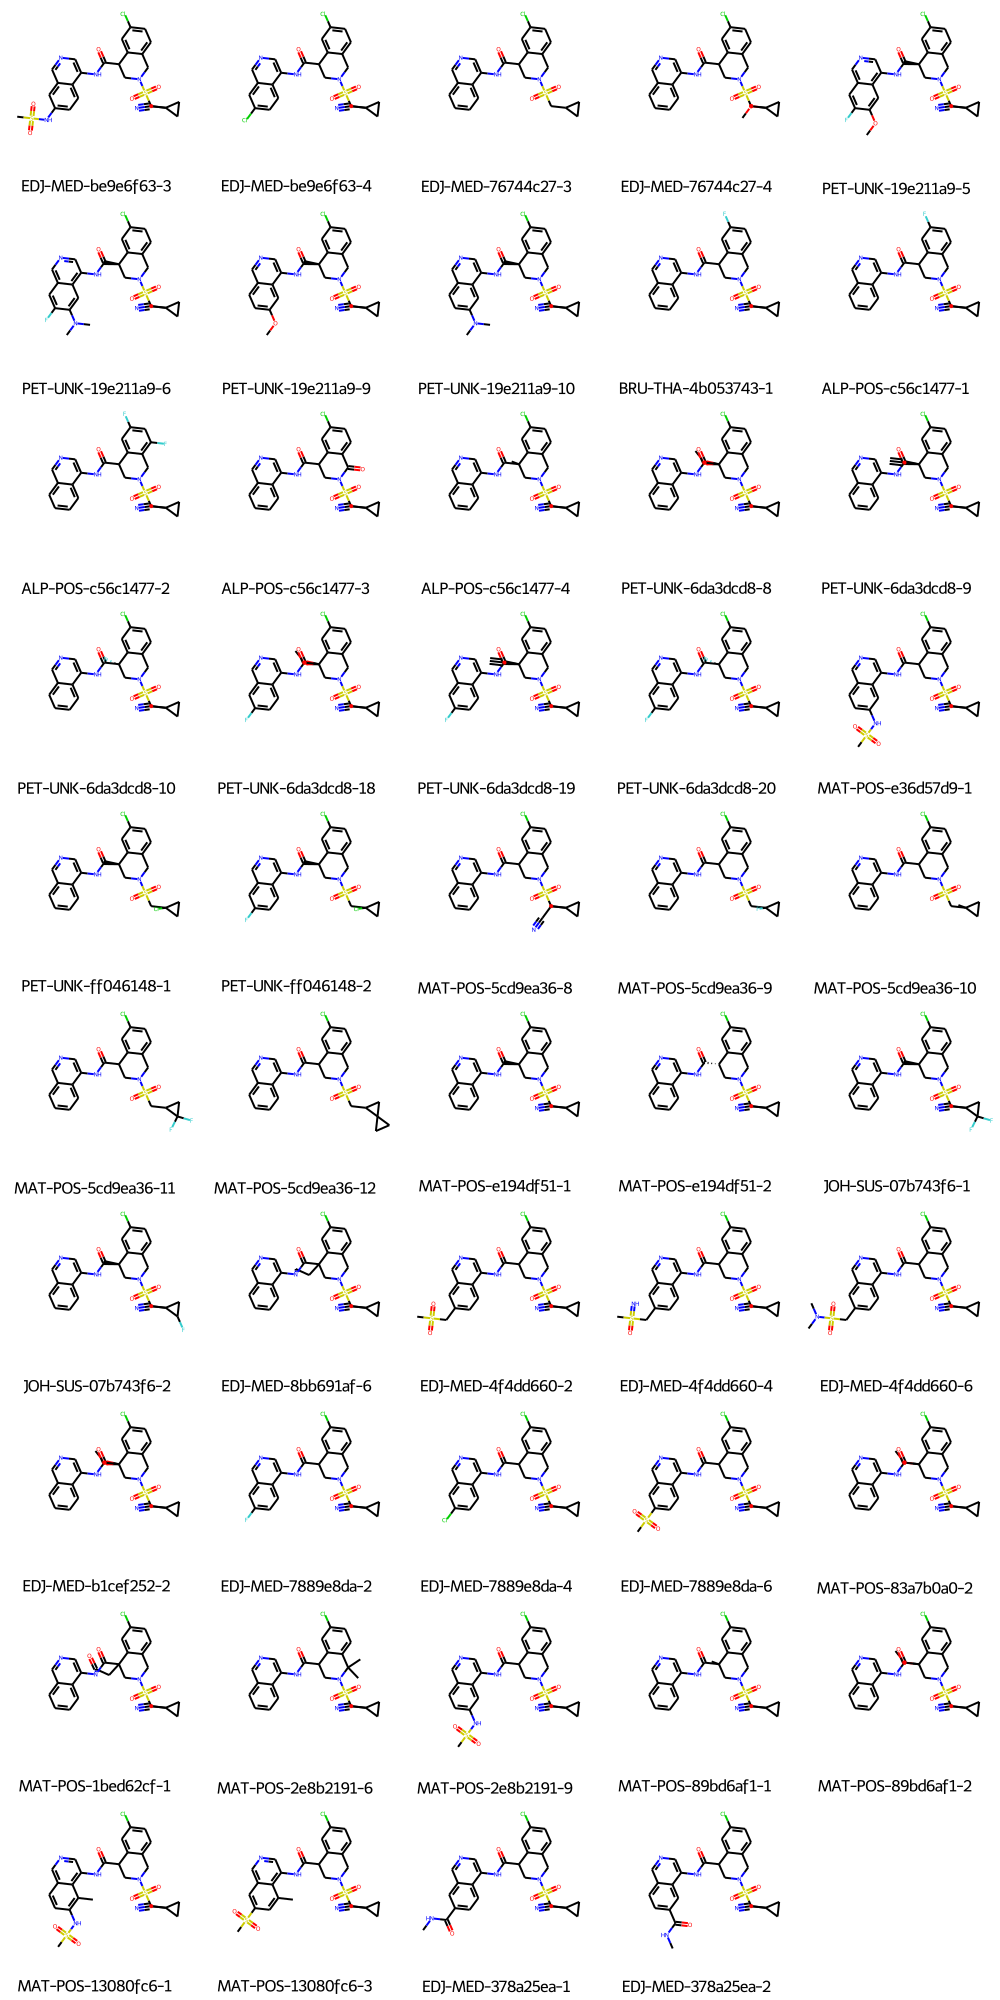

In [ ]:
# More broad Substructure Search


Chem.MolToSmiles(target_scaffold)


In [ ]:
simplified_sub_strucuture = Chem.MolFromSmiles('O=C(Nc1cncc2ccccc12)[C@@H]1CNCc2ccccc21')

In [ ]:
simplified_sub_strucuture_generic = MurckoScaffold.MakeScaffoldGeneric(simplified_sub_strucuture)
simplified_sub_strucuture_generic

In [ ]:
subms_larger = [(x,y) for x,y in ms if x.HasSubstructMatch(simplified_sub_strucuture)]

In [ ]:
len(subms_larger)

In [ ]:
subms_larger_generic = [(x,y) for x,y in ms_generic if x.HasSubstructMatch(simplified_sub_strucuture_generic)]

In [ ]:
len(subms_larger_generic)

In [ ]:
mols_to_show_2 = [x for x,y in subms_larger]

In [ ]:
n=4
Draw.MolsToGridImage(mols_to_show_2[n:n+49],molsPerRow=5)

In [ ]:
#subms_larger is the ligand series for max network testing

# Main Ligand Series

In [168]:
#Main ligand series
main_ligand_series = [
    "TRY-UNI-714a760b-6",
    "ADA-UCB-6c2cb422-1",
    "MAT-POS-b3e365b9-1",
    "MAT-POS-3ccb8ef6-1",
    "MAT-POS-24589f88-3",#This is not correctly stated in the preprint
    "MAT-POS-e194df51-1"
    
]

In [169]:
main_ligand_series

['TRY-UNI-714a760b-6',
 'ADA-UCB-6c2cb422-1',
 'MAT-POS-b3e365b9-1',
 'MAT-POS-3ccb8ef6-1',
 'MAT-POS-24589f88-3',
 'MAT-POS-e194df51-1']

In [170]:
main_ligand_series_mols = df[df["CID"].isin(main_ligand_series)][["SMILES","CID"]]

In [171]:
show_df(main_ligand_series_mols)

,SMILES,CID
129,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1,TRY-UNI-714a760b-6
8051,O=C(Cc1cccc(Cl)c1)Nc1cncc2ccccc12,ADA-UCB-6c2cb422-1
13654,O=C(Nc1cncc2ccccc12)[C@@H]1CCOc2ccc(Cl)cc21,MAT-POS-b3e365b9-1
17111,O=C(Nc1cncc2ccccc12)[C@@H]1CNCc2ccc(Cl)cc21,MAT-POS-3ccb8ef6-1
17915,CS(=O)(=O)N1Cc2ccc(Cl)cc2[C@H](C(=O)Nc2cncc3ccccc23)C1,MAT-POS-24589f88-3
19252,N#CC1(CS(=O)(=O)N2Cc3ccc(Cl)cc3[C@H](C(=O)Nc3cncc4ccccc34)C2)CC1,MAT-POS-e194df51-1


In [172]:
PandasTools.AddMoleculeColumnToFrame(main_ligand_series_mols,'SMILES','Molecule')

In [173]:
from rdkit.Chem.Scaffolds import MurckoScaffold

In [267]:
lead_stage_mols = list(main_ligand_series_mols["Molecule"])
#Getting scaffolds
lead_stage_mols = [MurckoScaffold.GetScaffoldForMol(x) for x in lead_stage_mols]
lead_stage_mols_generic = [MakeScaffoldGeneric(x) for x in lead_stage_mols]

In [268]:
smiles_list = list(df["SMILES"])
names_list = list(df["CID"])

In [277]:
ms_generic = []
fail_smiles = []
molecule_list = []

for c,(x,y) in enumerate(zip(smiles_list, names_list)):
    molecule_list.append((Chem.MolFromSmiles(x), y))
    try:
        ms_generic.append((MakeScaffoldGeneric(Chem.MolFromSmiles(x)), y))
    except:
        fail_smiles.append((x, y))
        
#subms_generic = [(x,y) for x,y in ms_generic if x.HasSubstructMatch(target_scaffold_generic)]

RDKit ERROR: [16:00:25] Explicit valence for atom # 9 C, 6, is greater than permitted
[16:00:25] Explicit valence for atom # 9 C, 6, is greater than permitted
RDKit ERROR: [16:00:26] Explicit valence for atom # 9 C, 6, is greater than permitted
RDKit ERROR: [16:00:26] Explicit valence for atom # 9 C, 6, is greater than permitted
RDKit ERROR: [16:00:26] Explicit valence for atom # 9 C, 6, is greater than permitted
[16:00:26] Explicit valence for atom # 9 C, 6, is greater than permitted
[16:00:26] Explicit valence for atom # 9 C, 6, is greater than permitted
[16:00:26] Explicit valence for atom # 9 C, 6, is greater than permitted
RDKit ERROR: [16:00:26] Explicit valence for atom # 13 C, 6, is greater than permitted
[16:00:26] Explicit valence for atom # 13 C, 6, is greater than permitted
RDKit ERROR: [16:00:26] Explicit valence for atom # 13 C, 6, is greater than permitted
[16:00:26] Explicit valence for atom # 13 C, 6, is greater than permitted
RDKit ERROR: [16:00:31] Explicit valence f

In [278]:
generic_array = []
for i in range(6):
    generic_array.append([(x,y) for x,y in ms_generic if x.HasSubstructMatch(lead_stage_mols_generic[i], useChirality=True)])

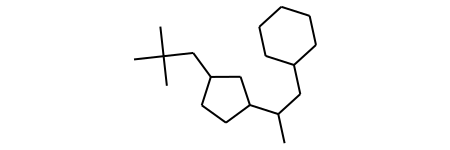

In [279]:
ms_generic[3][0]

In [280]:
actual_array = []
for i in range(6):
    actual_array.append([(x,y) for x,y in molecule_list if x.HasSubstructMatch(lead_stage_mols[i], useChirality=True)])

In [281]:
#Need a better generic function that preserves stereochemistry
#Suggest replace all heteroatoms with carbon

def MakeScaffoldGeneric(mol):
    res = Chem.Mol(mol)
    for atom in res.GetAtoms():
        if atom.GetAtomicNum() != 1:
            atom.SetAtomicNum(6)
        atom.SetIsAromatic(False)
        atom.SetFormalCharge(0)
        #atom.SetChiralTag(Chem.ChiralType.CHI_UNSPECIFIED)
        atom.SetNoImplicit(0)
        atom.SetNumExplicitHs(0)
    for bond in res.GetBonds():
        bond.SetBondType(Chem.BondType.SINGLE)
        bond.SetIsAromatic(False)
    return Chem.RemoveHs(res)

In [282]:
print("True - Generic")
for a,b in zip(actual_array, generic_array):
    print(len(a), len(b))

True - Generic
4815 7759
3848 4663
769 1399
397 1399
397 1399
42 45


In [283]:
from rdkit.Chem import AllChem
from rdkit.Chem import Draw,rdDepictor

def ShowSeriesGrid(mol_name_pair, n=0):
    mols_to_show = [x for x,y in mol_name_pair]
    names_to_show = [y for x,y in mol_name_pair]
    try:
        return Draw.MolsToGridImage(mols_to_show[n:n+49],legends=names_to_show[n:n+49],molsPerRow=5)
    except:
        return Draw.MolsToGridImage(mols_to_show,legends=names_to_show,molsPerRow=5)

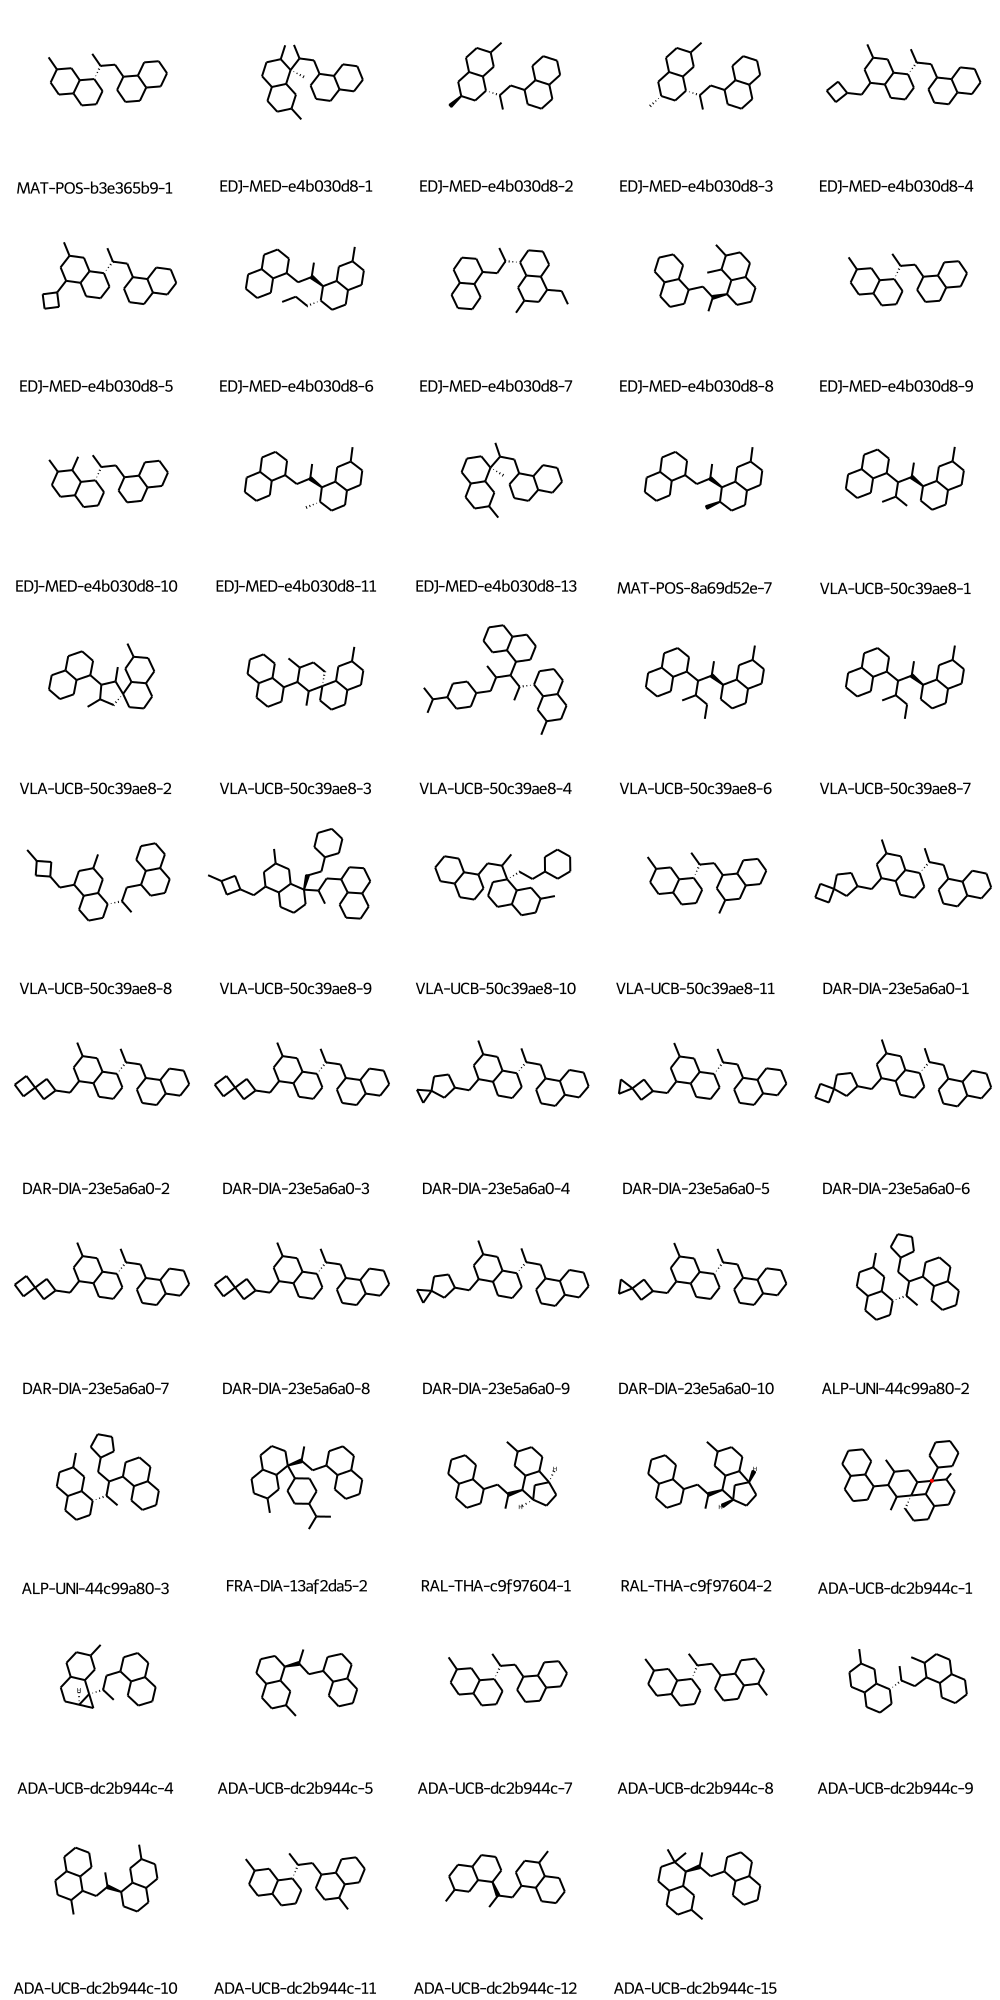

1399


In [284]:
idx = 2 # 2 is the theshold

display(ShowSeriesGrid(generic_array[idx]))
print(len(generic_array[idx]))

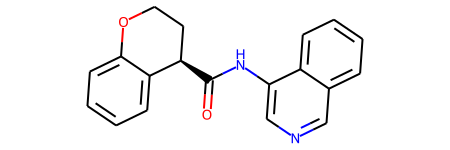

In [286]:
#Just scaffold
lead_stage_mols[idx]

In [287]:
#MurckoScaffold.GetScaffoldForMol(lead_stage_mols[idx])

In [288]:
names_to_use = [y for x,y in generic_array[idx]]

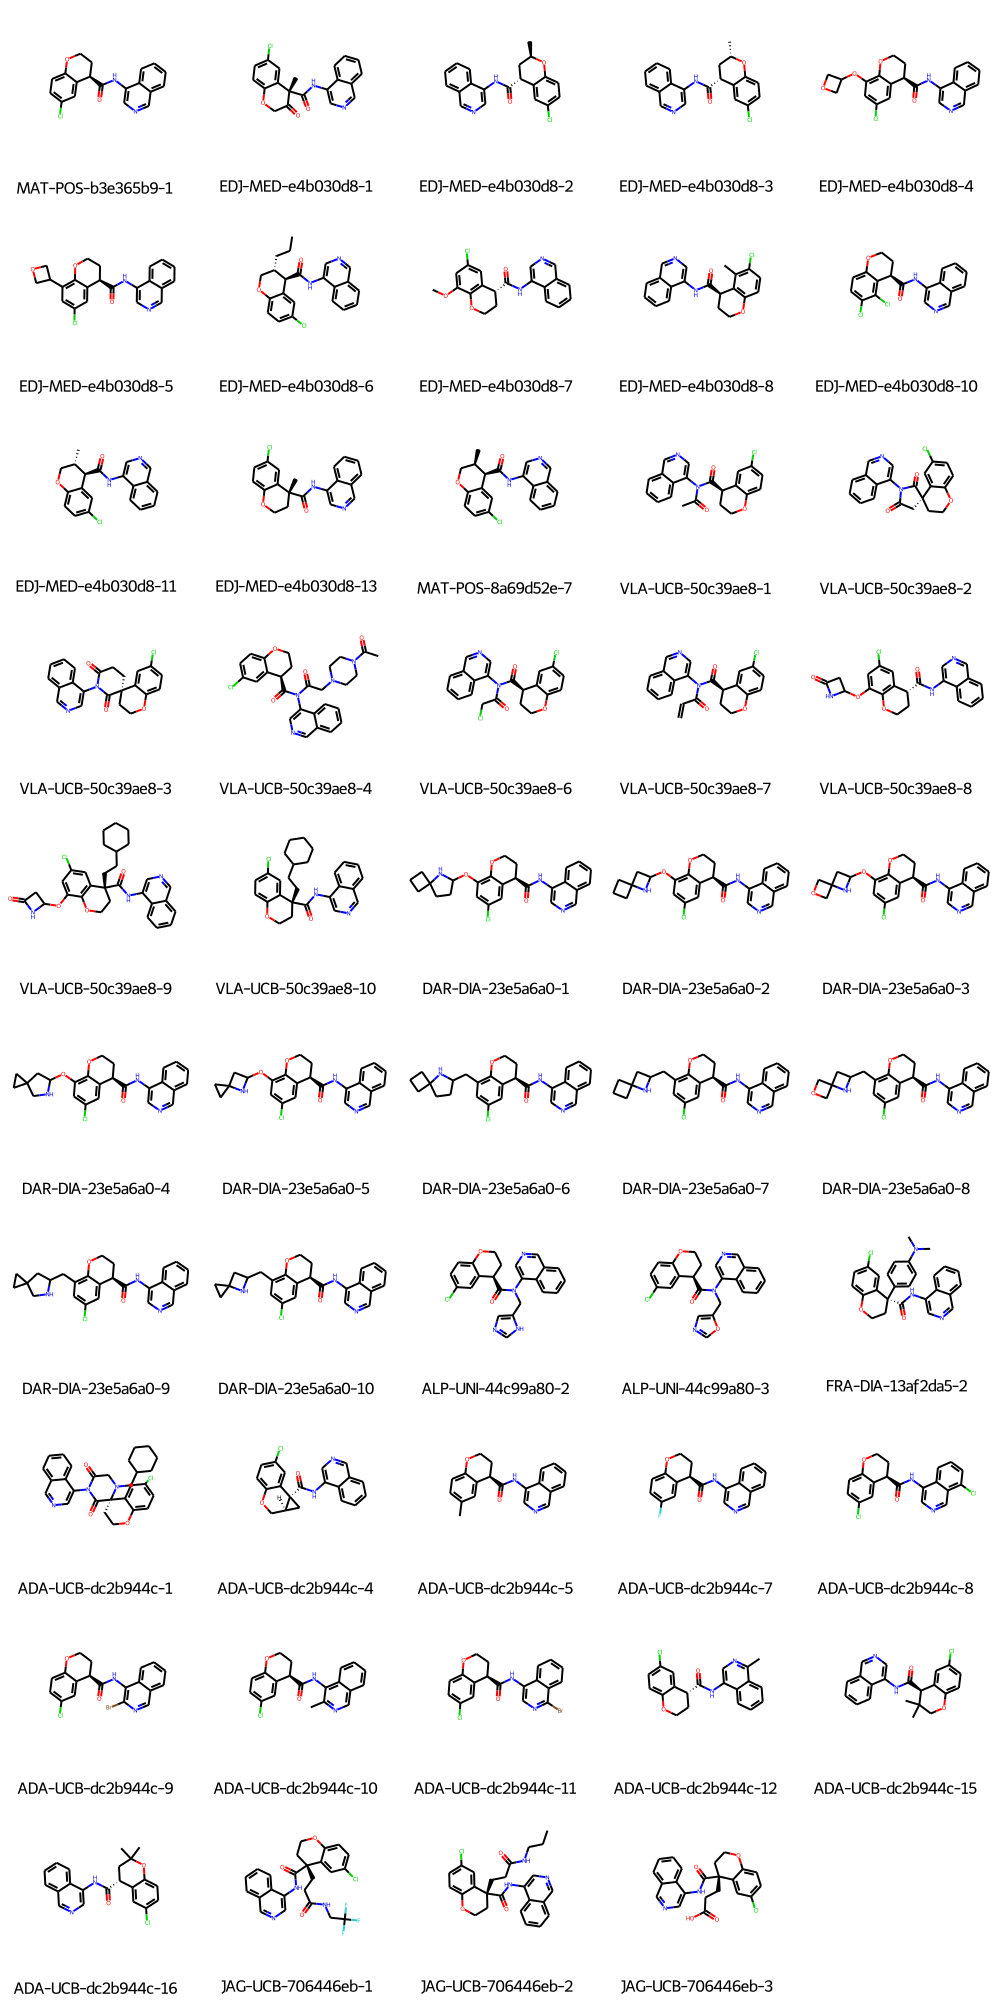

In [291]:
display(ShowSeriesGrid(actual_array[idx]))

In [292]:
print(len(actual_array[idx]))

769


In [293]:
#mol1_f = Chem.FragmentOnBonds(mol1, (0, 2, 4))

# Mega RBFENN

In [296]:
biggest_cluster = df[df["CID"].isin(names_to_use)][["CID","SMILES"]]

In [297]:
#biggest_cluster.to_csv(path_or_buf="big_cls_no_cl_b3e365b9.csv",index_label="index")

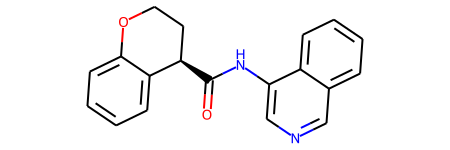

In [300]:
lead_stage_mols[2]

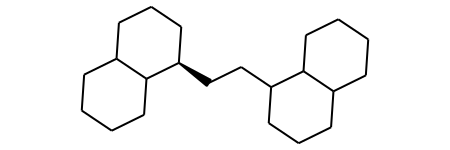

In [323]:
true_murcko_scaffold = MakeScaffoldGeneric(Chem.MolFromSmiles('C(Nc1cncc2ccccc12)[C@@H]1CCOc2ccccc21'))
true_murcko_scaffold

In [324]:
true_mucko_cluster = [(x,y) for x,y in ms_generic if x.HasSubstructMatch(true_murcko_scaffold, useChirality=True)]

In [325]:
len(true_mucko_cluster)

1405

In [331]:
names_to_use = [y for x,y in true_mucko_cluster]

In [334]:
#biggest_cluster = df[df["CID"].isin(names_to_use)][["CID","SMILES"]]
#biggest_cluster.to_csv(path_or_buf="big_cls_true_murcko_b3e365b9.csv",index_label="index")